# Purpose

Attempt to perform a logistic regression on the cves/metasploit dataset

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, fbeta_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import fbeta_score, make_scorer


%matplotlib inline


In [4]:
CVES_METASPLOIT_ENCODED = '../../data/processed/cves_metasplot_encoded.json'

In [5]:
cves_df = pd.read_json(CVES_METASPLOIT_ENCODED)
cves_df.head()

,id,metasploit,access_ADJACENT,access_LOCAL,access_NETWORK,auth_HIGH,auth_LOW,auth_NONE,avail_HIGH,avail_LOW,avail_NONE,comp_HIGH,comp_LOW,conf_HIGH,conf_LOW,conf_NONE,integ_HIGH,integ_LOW,integ_NONE
0,CVE-1999-0001,0,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,1
1,CVE-1999-0002,0,0,0,1,0,0,1,1,0,0,0,1,1,0,0,1,0,0
2,CVE-1999-0003,0,0,0,1,0,0,1,1,0,0,0,1,1,0,0,1,0,0
3,CVE-1999-0004,0,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,1
4,CVE-1999-0005,0,0,0,1,0,0,1,1,0,0,0,1,1,0,0,1,0,0


In [6]:
cves_df['metasploit'].value_counts()

0    126517
1      1833
Name: metasploit, dtype: int64

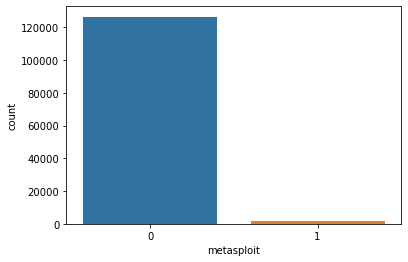

In [7]:
sns.countplot(x='metasploit', data=cves_df)

In [9]:
cves_df.groupby('metasploit').mean()

,access_ADJACENT,access_LOCAL,access_NETWORK,auth_HIGH,auth_LOW,auth_NONE,avail_HIGH,avail_LOW,avail_NONE,comp_HIGH,comp_LOW,conf_HIGH,conf_LOW,conf_NONE,integ_HIGH,integ_LOW,integ_NONE
metasploit,,,,,,,,,,,,,,,,,
0,0.022677,0.172720,0.804603,0.018622,0.149679,0.831699,0.372045,0.281614,0.346341,0.061992,0.938008,0.346823,0.367935,0.285242,0.315950,0.399251,0.284800
1,0.006001,0.081833,0.912166,0.008729,0.117840,0.873432,0.606110,0.270595,0.123295,0.049100,0.950900,0.624113,0.301691,0.074195,0.593562,0.265139,0.141298


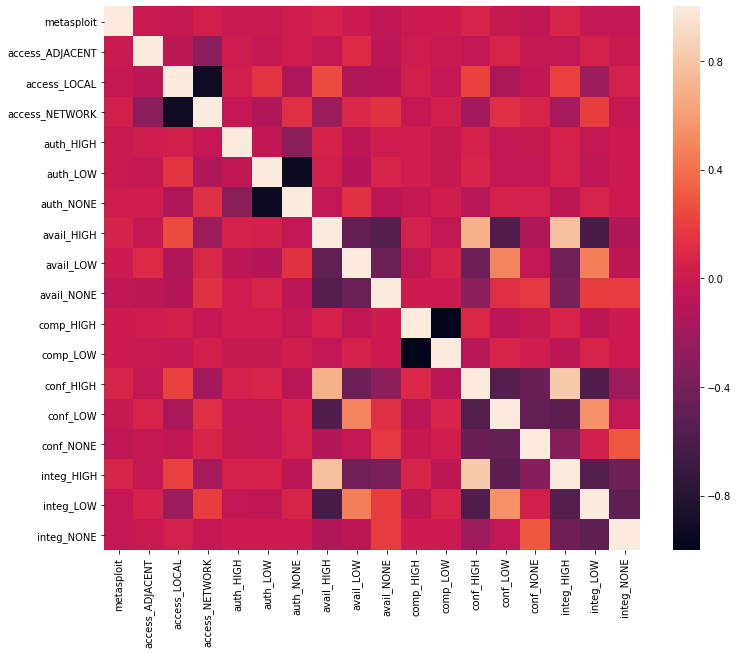

In [10]:
fig, ax = plt.subplots(figsize=(12,10))         # Sample figsize in inches

sns.heatmap(cves_df.corr(), ax=ax)
plt.savefig('../../docs/img/corr_heatmap.png')

In [11]:
cves_df.columns

Index(['id', 'metasploit', 'access_ADJACENT', 'access_LOCAL', 'access_NETWORK',
       'auth_HIGH', 'auth_LOW', 'auth_NONE', 'avail_HIGH', 'avail_LOW',
       'avail_NONE', 'comp_HIGH', 'comp_LOW', 'conf_HIGH', 'conf_LOW',
       'conf_NONE', 'integ_HIGH', 'integ_LOW', 'integ_NONE'],
      dtype='object')

In [12]:
X = cves_df.drop(['metasploit', 'id'], axis=1)
y = cves_df['metasploit']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [13]:
y_train.mean()

0.014387816583906423

In [14]:
y_test.mean()

0.013961605584642234

In [15]:
classifier = LogisticRegression(random_state=0, class_weight="balanced")
classifier.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [16]:
y_pred = classifier.predict(X_test)

In [17]:
pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
True,,,
0,19702,11938,31640
1,128,320,448
All,19830,12258,32088


In [18]:
print(confusion_matrix(y_test, y_pred))

[[19702 11938]
 [  128   320]]


In [19]:
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(classifier.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.62


In [21]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.62      0.77     31640
           1       0.03      0.71      0.05       448

    accuracy                           0.62     32088
   macro avg       0.51      0.67      0.41     32088
weighted avg       0.98      0.62      0.76     32088



out of the 31640 CVEs we have only 448 of them required us to inspect them, the predictor said to inspect 12258, so we looked at nearly 40%, or another way, we had a 60% reduction in cves to inspect.  That's good, but not great, specially since it resulted in missing nearly 25% of the positives: 128 were exploited without triggering a positive.  Much like SPAM, we want to minimize False Negatives

In [23]:
y_pred_prob = classifier.predict_proba(X_test)

In [24]:
thresh = .7
y_pred_thresh = [1 if pred[1] > thresh else 0 for pred in y_pred_prob]
matrix = confusion_matrix(y_test, y_pred_thresh)
(matrix[1][0], matrix[0][1]+matrix[1][1])

(249, 5932)

In [25]:
def get_rates(thresh):
    y_pred_thresh = [1 if pred[1] > thresh else 0 for pred in y_pred_prob]
    matrix = confusion_matrix(y_test, y_pred_thresh)
    return matrix

results = []
for a in range(100, 0, -1):
    thresh = a/100
    matrix = get_rates(thresh)
    results.append((thresh, matrix))

In [26]:
results[50][1]

array([[19702, 11938],
       [  128,   320]], dtype=int64)

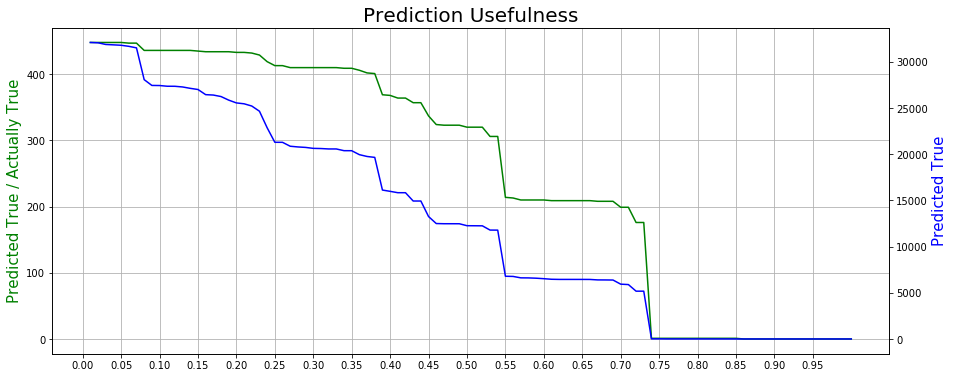

In [27]:
# Lets plot True-Positives against all True
title_size=20
labelsize=15
ticksize=10

thresh_x = [x[0] for x in results]
tp_y = [x[1][1][1] for x in results]
t_y = [x[1][0][1]+x[1][1][1] for x in results]

fig, ax1 = plt.subplots(figsize=(15,6))

ax2 = ax1.twinx()
ax1.plot(thresh_x, tp_y, 'g')
ax2.plot(thresh_x, t_y, 'b')

plt.title('Prediction Usefulness', fontsize=title_size)
ax1.set_ylabel('Predicted True / Actually True', color='g', fontsize=labelsize)
ax2.set_ylabel('Predicted True', color='b', fontsize=labelsize)
plt.xlabel('Threshold', fontsize=labelsize)
xticks = [x/100 for x in range(0,100,5)]
plt.xticks(xticks)
ax1.grid(True)
plt.savefig('../../docs/img/avp.png')

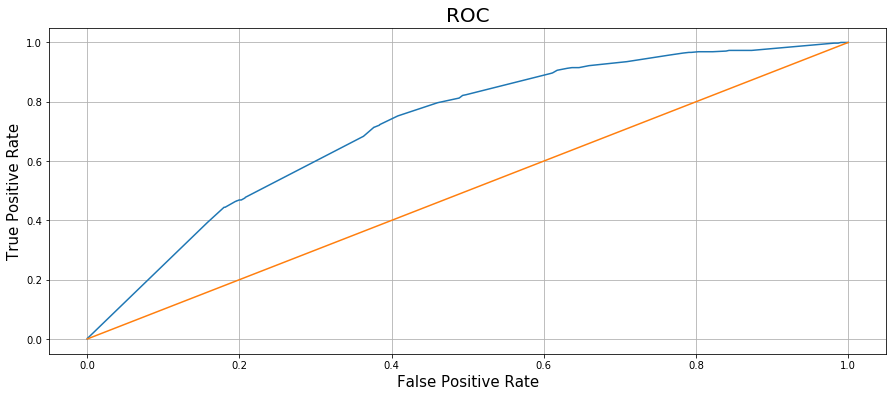

In [36]:
# lets plot the ROC curve now
# true positive rate (TPR) against the false positive rate (FPR)
title_size=20
labelsize=15
ticksize=10

# Num FP / 
tp_rate_y = [x[1][1][1]/(x[1][1][1]+x[1][1][0]) for x in results]
fp_rate_x = [x[1][0][1]/(x[1][0][1]+x[1][0][0]) for x in results]

fig, ax1 = plt.subplots(figsize=(15,6))

ax1.plot(fp_rate_x, tp_rate_y)
ax1.plot([0,1], [0,1])
plt.title('ROC', fontsize=title_size)
ax1.set_ylabel('True Positive Rate', fontsize=labelsize)
ax1.set_xlabel('False Positive Rate', fontsize=labelsize)

ax1.tick_params(labelsize=ticksize)
ax1.grid(True)
plt.savefig('../../docs/img/roc.png')



In [30]:
thresh = 0.5
y_pred_thresh = np.array([1 if pred[1] > thresh else 0 for pred in y_pred_prob])
matrix = confusion_matrix(y_test, y_pred_thresh)
display(pd.crosstab(y_test, y_pred_thresh, rownames=['True'], colnames=['Predicted'], margins=True))
print(matrix)
print(classification_report(y_test, y_pred_thresh))
print("F10 Score        :", fbeta_score(y_test, y_pred_thresh, 10))

Predicted,0,1,All
True,,,
0,19702,11938,31640
1,128,320,448
All,19830,12258,32088


[[19702 11938]
 [  128   320]]
              precision    recall  f1-score   support

           0       0.99      0.62      0.77     31640
           1       0.03      0.71      0.05       448

    accuracy                           0.62     32088
   macro avg       0.51      0.67      0.41     32088
weighted avg       0.98      0.62      0.76     32088

F10 Score        : 0.5664411651302182


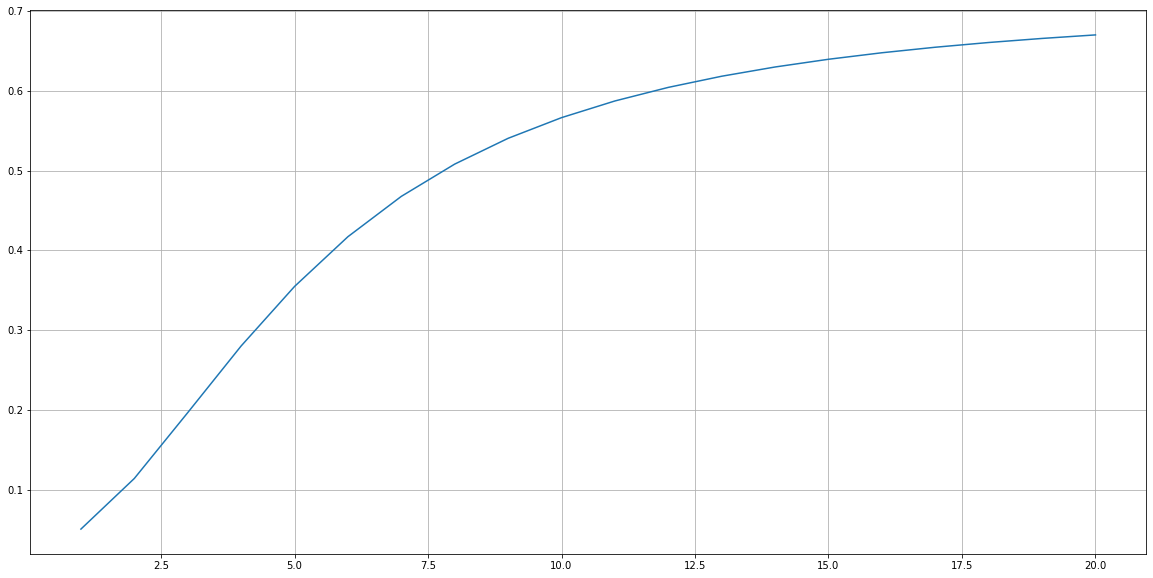

In [31]:
fbeta_test = [(fbeta, fbeta_score(y_test, y_pred_thresh, fbeta)) for fbeta in range(1, 21)]
fbeta_test_y = [test[0] for test in fbeta_test]
fbeta_test_x = [test[1] for test in fbeta_test]
plt.figure(figsize=(20,10))
plt.plot(fbeta_test_y, fbeta_test_x)
plt.grid(True)

In [33]:
# lets check all f-betas from 1-10 in increments of 2

def f_beta_score(thresh, fbeta):
    y_pred_thresh = [1 if pred[1] > thresh else 0 for pred in y_pred_prob]
    score = fbeta_score(y_test, y_pred_thresh, fbeta)
    return score

def get_f_beta_scores(fbeta):
    fscore_results = []
    for a in range(100, 0, -1):
        thresh = a/100
        score = f_beta_score(thresh, fbeta)
        fscore_results.append((thresh, score))
    return fscore_results

all_fscore_results = [(fbeta, get_f_beta_scores(fbeta)) for fbeta in range(2, 21, 2)]

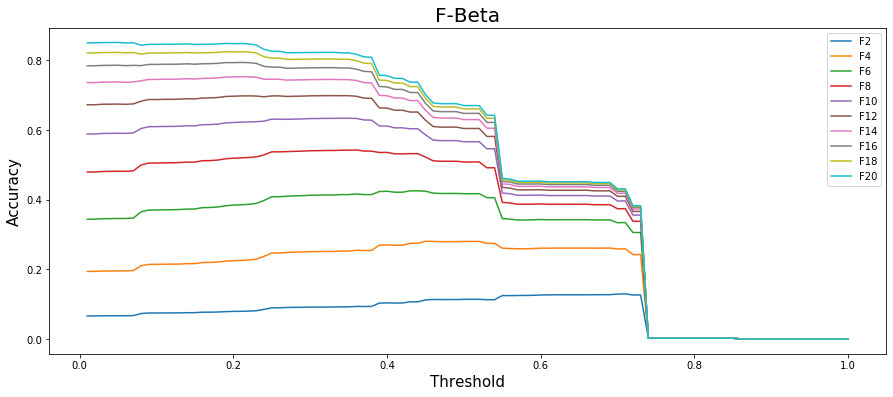

In [35]:

title_size=20
labelsize=15
ticksize=10

thresh_x = [x[0] for x in all_fscore_results[0][1]]

plt.figure(figsize=(15,6))
for i, fscore_result in enumerate(all_fscore_results):
    
    fscore = all_fscore_results[i][0]
    next_y = [x[1] for x in all_fscore_results[i][1]]

    plt.plot(thresh_x, next_y, label='F{0}'.format(fscore))

plt.legend()

plt.title('F-Beta', fontsize=title_size)
plt.xlabel('Threshold', fontsize=labelsize)
plt.ylabel('Accuracy', fontsize=labelsize)
plt.tick_params(labelsize=ticksize)
plt.savefig('../../docs/img/f-beta.png')


Using the above f10 was decided to be used as our scoring

In [37]:
param_grid = [
  {'C': [0.1, 0.25, 0.5, 0.75, 1, 10, 100, 1000]}
 ]

# Using balanced since we have a 60:1 of negatives:positives
model = LogisticRegression(random_state=0, class_weight="balanced")

f10_scorer = make_scorer(fbeta_score, beta=10)

grid_search_model = GridSearchCV(model, param_grid=param_grid, scoring=f10_scorer, cv=5, n_jobs=-1)

grid_search_model.fit(X_train, y_train)

print(grid_search_model)
print(grid_search_model.best_score_)
print(grid_search_model.best_params_)

GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight='balanced',
                                          dual=False, fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=0, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid=[{'C': [0.1, 0.25, 0.5, 0.75, 1, 10, 100, 1000]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(fbeta_score, beta=10), verbose=0)
0.5905353653484405
{'C': 0.1}


In [38]:
model = LogisticRegression(C=0.25, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=0,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

display(pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True))
print("Training Accuracy:", model.score(X_train, y_train))
print("Test Accuracy    :", model.score(X_test, y_test))
print("F10 Score        :", fbeta_score(y_test, y_pred, 10))
print()
print(classification_report(y_test, y_pred))


Predicted,0,1,All
True,,,
0,19702,11938,31640
1,128,320,448
All,19830,12258,32088


Training Accuracy: 0.6222289169142549
Test Accuracy    : 0.6239715781600599
F10 Score        : 0.5664411651302182

              precision    recall  f1-score   support

           0       0.99      0.62      0.77     31640
           1       0.03      0.71      0.05       448

    accuracy                           0.62     32088
   macro avg       0.51      0.67      0.41     32088
weighted avg       0.98      0.62      0.76     32088



In [40]:
X_train.columns

Index(['access_ADJACENT', 'access_LOCAL', 'access_NETWORK', 'auth_HIGH',
       'auth_LOW', 'auth_NONE', 'avail_HIGH', 'avail_LOW', 'avail_NONE',
       'comp_HIGH', 'comp_LOW', 'conf_HIGH', 'conf_LOW', 'conf_NONE',
       'integ_HIGH', 'integ_LOW', 'integ_NONE'],
      dtype='object')

In [41]:
print(model.coef_)

[[-0.87558787 -0.4217478   0.80743572 -0.6235629   0.01629935  0.11736359
  -0.21488296  0.53032826 -0.80534525 -0.35053658 -0.13936337  0.46482133
   0.17506591 -1.12978718  0.47258349 -0.81340118 -0.14908225]]


In [42]:
print(sorted(model.coef_[0]))

[-1.1297871787836962, -0.8755878701504194, -0.8134011846350171, -0.8053452480674879, -0.6235628951987201, -0.42174779612637625, -0.35053658072956745, -0.2148829590104657, -0.1490822514158988, -0.13936336551010162, 0.01629935452501043, 0.1173635944215625, 0.17506590610823305, 0.4648213264295889, 0.4725834898160646, 0.5303282608424451, 0.8074357200454538]


In [43]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
print("F10 Score Train:", fbeta_score(y_train, y_pred_train, 10))
print("F10 Score Test :", fbeta_score(y_test, y_pred_test, 10))



F10 Score Train: 0.59035389558599
F10 Score Test : 0.5664411651302182
